# Footprint the extents of rasters

In [1]:
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling

import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import box
import fiona
from fiona.crs import from_epsg
import pprint

import glob
import os


# https://gis.stackexchange.com/questions/375577/how-do-i-write-out-a-mixed-geometry-geodataframe-to-a-geopackage
# https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
def resample_raster(raster, out_path=None, scale=2):
    """ Resample a raster
        multiply the pixel size by the scale factor
        divide the dimensions by the scale factor
        i.e
        given a pixel size of 250m, dimensions of (1024, 1024) and a scale of 2,
        the resampled raster would have an output pixel size of 500m and dimensions of (512, 512)
        given a pixel size of 250m, dimensions of (1024, 1024) and a scale of 0.5,
        the resampled raster would have an output pixel size of 125m and dimensions of (2048, 2048)
        returns a DatasetReader instance from either a filesystem raster or MemoryFile (if out_path is None)
    """
    data, profile = get_data_from_resample(raster, scale)

    if out_path is None:
        with write_mem_raster(data, **profile) as dataset:
            del data
            yield dataset

    else:
        with write_raster(out_path, data, **profile) as dataset:
            del data
            yield dataset


def write_mem_raster(data, **profile):
    with MemoryFile() as memfile:
        with memfile.open(**profile) as dataset:  # Open as DatasetWriter
            dataset.write(data)

        with memfile.open() as dataset:  # Reopen as DatasetReader
            yield dataset  # Note yield not return


def write_raster(path, data, **profile):

    with rasterio.open(path, 'w', **profile) as dataset:  # Open as DatasetWriter
        dataset.write(data)

    with rasterio.open(path) as dataset:  # Reopen as DatasetReader
        yield dataset

'''
def do_resample(dataset, scale_factor):
    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * scale_factor),
            int(dataset.width * scale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
    return data, transform
'''
def get_data_from_resample(dataset, scale_factor):
    t = dataset.transform

    # rescale the metadata
    transform = Affine(t.a * scale_factor, t.b, t.c, t.d, t.e * scale_factor, t.f)
    height = int(raster.height / scale_factor)
    width = int(raster.width / scale_factor)

    profile = raster.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width)

    data = dataset.read(
            out_shape=(dataset.count, height, width),
            resampling=Resampling.bilinear,
        )
    
    return data, profile

def r_getgeom(r_fn, TO_GCS = True, scale_factor=100, out_res=250):
    
    '''Function to get a raster mask and other info to make a raster footprint'''
    
    # Alt attempt: use pygeotools to write out a coarsened raster that gets footprinted
    # This is slower and creates intermediate coarsened files..not ideal
    #warplib.diskwarp_multi_fn( [r_fn], res=out_res, extent='first', t_srs='first', r='cubic', verbose=True, outdir=os.path.dirname(r_fn), dst_ndv=None):
    
    with rasterio.open(r_fn) as dataset:
        name = os.path.basename(r_fn)
        # Attempt to use rasterio to downsample with a scale factor, the create a dataset that gets footprinted..
        # TODO: this was a fail - try to do it correctly
        #out_fn = os.path.splitext(r_fn)[0] + f'_sf{scale_factor}.tif'
        #dataset = resample_raster(dataset, out_path=out_fn, scale=scale_factor)
        
        
        # Read the dataset's valid data mask as a ndarray.
        data = dataset.read(1)
        mask = dataset.dataset_mask()
        data_crs = dataset.crs
        
        if False:
            results = (
                {'properties': {'raster_val': v}, 'geometry': s} for i, (s, v) in enumerate(rasterio.features.shapes(mask, transform=dataset.transform))
            )
            geom = list(results)
            print(geom[-1])
        else:
            # Extract feature shapes and values from the array.
            # TODO: this might only get 1 of the geoms?
            
            #for geom, val in rasterio.features.shapes(data, mask=mask, transform=dataset.transform):
            for geom, val in rasterio.features.shapes(mask, transform=dataset.transform):
            #for geom, val in rasterio.features.shapes(data=dataset.read(1), transform=dataset.transform):

                if TO_GCS:
                    # Transform shapes from the dataset's own coordinate
                    # reference system to CRS84 (EPSG:4326).
                    geom = rasterio.warp.transform_geom(
                        dataset.crs, 'EPSG:4326', geom, precision=6)
                    #geom_list.append(geom)

                #print(val)
            print(geom)
            
        return geom, name, os.path.basename(r_fn), data_crs
    
def raster_footprint_gdf(r_fn_list, OUT_F_NAME='footprints.gpkg', OUT_LYR_NAME='footprints', TO_GCS=False, WRITE_GPKG=True):
    
    # Build the components of the GeoDataFrame dict
    polys = [r_getgeom(r_fn, TO_GCS=False)[0] for r_fn in r_fn_list ]    
    names = [r_getgeom(r_fn, TO_GCS=False)[1] for r_fn in r_fn_list ]  
    files = [r_getgeom(r_fn, TO_GCS=False)[2] for r_fn in r_fn_list ]
    
    # Use shapely to convert list of polys to actual shape geoms
    geoms = [shapely.geometry.shape(i) for i in polys]
    
    # Return the CRS for output
    out_crs = r_getgeom(r_fn_list[0], TO_GCS=TO_GCS)[3]
    
    # Build the GeoDataFrame
    #footprints_gdf  = gpd.GeoDataFrame.from_features(polys)
    footprints_gdf = gpd.GeoDataFrame({'geometry':geoms, 'name':names, 'file':files}, crs=out_crs)
    
    if not TO_GCS:
        # Get area
        footprints_gdf["area_km2"] = footprints_gdf['geometry'].area/1000000
        footprints_gdf["area_ha"] = footprints_gdf['geometry'].area/10000
           
    if WRITE_GPKG:
        footprints_gdf.to_file(OUT_F_NAME, driver="GPKG", layer=OUT_LYR_NAME)
        print(f"Wrote out spatial footprints to {OUT_F_NAME}")
    
    return footprints_gdf

def get_geom_from_datasetmask(rio_dataset, GET_ONLY_DATASETMASK=True):
    
    if GET_ONLY_DATASETMASK:
        results = (
                    {'properties': {'raster_value': v}, 'geometry': s} for i, (s, v) in enumerate(rasterio.features.shapes(rio_dataset.dataset_mask(), transform=rio_dataset.transform))
                )
    else:
        results = (
                    {'properties': {'raster_value': v}, 'geometry': s} for i, (s, v) in enumerate(rasterio.features.shapes(rio_dataset.read_masks(), transform=rio_dataset.transform))
                )
        
    geom = list(results)

    #return(geom, rio_dataset.crs)
    return(geom)

def get_geom_from_bounds(rio_dataset, footprint_name=None):
    #result=[{"properties":{"id":1},"geometry": [mapping(box(*rio_dataset.bounds))] } ]
    ##geom = {'properties': {'raster_val': None }, 'geometry': mapping(box(*rio_dataset.bounds)) } 
    #geom = {'properties': {'raster_val': None }, 'geometry': {'type': 'Polygon', 'coordinates': [box(*rio_dataset.bounds)] } } 
    results = [{"properties":{'footprint_name': footprint_name}, "geometry": {'type': 'Polygon', 'coordinates': [list(box(*rio_dataset.bounds).exterior.coords)] } } ]
    geom = list(results)
    return(geom)

def raster_footprint(r_fn, DO_DATAMASK=True, GET_ONLY_DATASETMASK=True, R_READ_MODE='r+'):
    
    with rasterio.open(r_fn, mode=R_READ_MODE) as dataset:
        
        if DO_DATAMASK:
            if GET_ONLY_DATASETMASK:
                job_string = 'valid data mask (high memory)'
            else:
                job_string = 'valid data mask + the nodata (most memory)'
            #geom, dataset.crs = get_geom_from_datasetmask(dataset)
            geom = get_geom_from_datasetmask(dataset, GET_ONLY_DATASETMASK=GET_ONLY_DATASETMASK)
            
        else:
            job_string = 'raster image bounds (low memory)'
            geom = get_geom_from_bounds(dataset)
        
        
        footprints_gdf  = gpd.GeoDataFrame.from_features(geom, crs=dataset.crs)
        #print(footprints_gdf.crs.axis_info[0].unit_name)
        #print(dataset.crs)
        
        footprints_gdf['path'], footprints_gdf['file'] = os.path.split(r_fn)

        if False:
            print(f'Getting {job_string} for: {os.path.basename(r_fn)} ...')
        
        if 'm' in footprints_gdf.crs.axis_info[0].unit_name:
            # Get area
            footprints_gdf["area_km2"] = footprints_gdf['geometry'].area/1e6
            footprints_gdf["area_ha"] = footprints_gdf['geometry'].area/1e4
                    
        return footprints_gdf
    
def build_footprint_db(gdf_list, TO_GCS=True, WRITE_GPKG=True, OUT_F_NAME='footprints.gpkg', OUT_LYR_NAME='footprints'):
    
    print("Building GDF from list...")
    footprints_gdf = gpd.GeoDataFrame( pd.concat( gdf_list, ignore_index=True) )
    
    if TO_GCS:
        print("Converting to GCS...")
        footprints_gdf = footprints_gdf.to_crs({'init': 'epsg:4326'})
        
    if WRITE_GPKG:
        footprints_gdf.to_file(OUT_F_NAME, driver="GPKG", layer=OUT_LYR_NAME)
        print(f"Wrote out spatial footprints to {OUT_F_NAME}")
        
    return footprints_gdf

### Set up dictionaries of parameters

Set up an AWSSession

In [17]:
import configparser
config = configparser.ConfigParser()
config.read('/home/pmontesa/credentials_test')
print(config.sections()[0])
[print(key) for key in config['boreal_pub']]
config['boreal_pub']['aws_access_key_id']


boreal_pub
aws_access_key_id
aws_secret_access_key


'1234567'

In [22]:
import rasterio as rio
from matplotlib.pyplot import imshow
from rasterio.session import AWSSession
import boto3
import pandas as pd

credentials_fn = '/home/pmontesa/credentials_test' #'/efs/pmontesa/credentials'

def parse_aws_creds(credentials_fn):
    
    import configparser
    
    config = configparser.ConfigParser()
    config.read(credentials_fn)
    profile_name = config.sections()[0]
    #[print(key) for key in config['boreal_pub']]
    aws_access_key_id = config['boreal_pub']['aws_access_key_id']
    aws_secret_access_key = config['boreal_pub']['aws_secret_access_key']
    
    if False:
        credentials_df = pd.read_csv(credentials_fn, sep=" ", header=None)
        profile_name=credentials_df.iloc[0].to_list()[0].replace(']','').replace('[','')
        aws_access_key_id = credentials_df.iloc[1].to_list()[0].split("=")[1]
        aws_secret_access_key = credentials_df.iloc[2].to_list()[0].split("=")[1]
    
    return profile_name, aws_access_key_id, aws_secret_access_key

def get_rio_aws_session_from_creds(credentials_fn):
    
    import s3fs
    import rasterio as rio
    from rasterio.session import AWSSession
    import boto3
    import pandas as pd
    
    profile_name, aws_access_key_id, aws_secret_access_key = parse_aws_creds(credentials_fn)

    boto3_session = boto3.Session(
            aws_access_key_id=aws_access_key_id,
            aws_secret_access_key=aws_secret_access_key,
            #aws_session_token=credentials['SessionToken'],
            profile_name=profile_name
        )

    rio_aws_session = AWSSession(boto3_session)
    
    return rio_aws_session

def get_s3_fs_from_creds():
    
    profile_name, aws_access_key_id, aws_secret_access_key = parse_aws_creds(credentials_fn)

    s3_fs = s3fs.S3FileSystem(profile=profile_name, key=aws_access_key_id, secret=aws_secret_access_key)

    return s3_fs

In [23]:
parse_aws_creds(credentials_fn)

('boreal_pub', '1234567', 'qwertyuiop')

In [26]:
dict_list = [

        {'location':'s3',
         'data_dir': "s3://terrapulse-pub-data/boreal-forest-data",
         'data_source': 'terrapulse-pub-data',
         'image_type': 'tcc_2020',
         'search_tail_string': '/**/*.tif',
         'search_link_string': '',
         'DO_DATAMASK': False,
         'GET_ONLY_DATASETMASK': True,
         'out_footprint_dir': '/efs/projects/forest_height/test_out',
         'footprint_name_SPLIT_CHAR': '_',
         'footprint_name_SPLIT_POS': 0,
         'aws_credential_fn': '/efs/pmontesa/credentials'
         #'profile':'boreal_pub',
         #'key': aws_access_key_id, 
         #'secret': aws_secret_access_key
        }
]

for d in dict_list:
    print(d['data_source'])

s3.ls(d['data_dir'])

terrapulse-pub-data


['terrapulse-pub-data/boreal-forest-data/datasets_readme.pdf',
 'terrapulse-pub-data/boreal-forest-data/forest_age',
 'terrapulse-pub-data/boreal-forest-data/forest_loss',
 'terrapulse-pub-data/boreal-forest-data/tcc_2020',
 'terrapulse-pub-data/boreal-forest-data/tcc_pvalue',
 'terrapulse-pub-data/boreal-forest-data/tcc_slope']

### Run the footprinting code over an s3 datalist to return and geodataframe and a geopackage **updated** 

https://stackoverflow.com/questions/67812512/rasterio-does-not-exist-in-the-file-system-and-is-not-recognized-as-a-support

In [27]:
%%time

TEST=False

footprint_gdf_list = list()
for d in dict_list:
    
    filename = 'footprints_' + d['data_source']+'_'+d['image_type']+'.gpkg'
    
    #SEARCH_STR_LIST = ["/", sensor, image_type, ".tif"]
    SEARCH_STR_LIST = ["/", d['image_type'], d['search_tail_string']]
    keystring = d['search_link_string'].join(SEARCH_STR_LIST)
    print(keystring)
    
    # Raster list
    if d['location'] == 'local':
        r_fn_list = glob.glob(d['data_dir'] + keystring)
    else:
        print('on s3...')
        r_fn_list = s3.glob(d['data_dir'] + keystring)
        r_fn_list = ['s3://' + f for f in r_fn_list]
        
    if TEST:
        r_fn_list = r_fn_list[0:2]
        print(r_fn_list)
        filename = 'TEST_footprints_' + d['data_source']+'_'+d['image_type']+'.gpkg'
    
    
    ootprint_fn = os.path.join(d['out_footprint_dir'], filename)
    
    print(f'{len(r_fn_list)} total inputs from ' + d['data_source'] )    
    
    with rio.Env(aws_session):
        # Get a list geodataframes of indiv raster footprint geometries (both data and mask)
        f_gdf_lst = [raster_footprint(r_fn, DO_DATAMASK=d['DO_DATAMASK'], GET_ONLY_DATASETMASK=d['GET_ONLY_DATASETMASK'], R_READ_MODE='r') for r_fn in r_fn_list]

    # Build a footprint database geodataframe from all rasters
    footprint_gdf = build_footprint_db(f_gdf_lst, TO_GCS=True, WRITE_GPKG=True, OUT_F_NAME=ootprint_fn, OUT_LYR_NAME=d['image_type'])
    footprint_gdf['footprint_name'] = footprint_gdf['file'].str.split(d['footprint_name_SPLIT_CHAR'], expand=True)[d['footprint_name_SPLIT_POS']]
    footprint_gdf_list.append(footprint_gdf)

/tcc_2020/**/*.tif
on s3...
649 total inputs from terrapulse-pub-data
Building GDF from list...
Converting to GCS...
Wrote out spatial footprints to /efs/projects/forest_height/test_out/footprints_terrapulse-pub-data_tcc_2020.gpkg
CPU times: user 16.2 s, sys: 652 ms, total: 16.9 s
Wall time: 6min 37s


#### Test access to rasters on s3

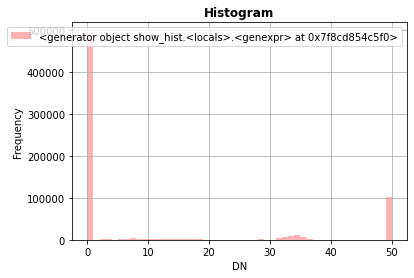

In [10]:
test_terraPulse_file = r_fn_list[1]

import rioxarray as rxr

with rio.Env(aws_session):
    #arr= rxr.open_rasterio(test_terraPulse_file,  masked=False)
    
    with rio.open(test_terraPulse_file) as src:
        profile = src.profile
        arr = src.read(1)
        #arr.plot()
        from rasterio.plot import show_hist
        show_hist(
            src, bins=50, lw=0.0, stacked=False, alpha=0.3,
            histtype='stepfilled', title="Histogram")

In [28]:
footprint_gdf = footprint_gdf_list[0]
footprint_gdf

,geometry,footprint_name,path,file
0,"POLYGON ((7.50000 57.50000, 7.50000 60.00000, ...",005E,s3://terrapulse-pub-data/boreal-forest-data/tc...,005E_60N_tcc_2020.tif
1,"POLYGON ((10.00000 57.50000, 10.00000 60.00000...",008E,s3://terrapulse-pub-data/boreal-forest-data/tc...,008E_60N_tcc_2020.tif
2,"POLYGON ((10.00000 60.00000, 10.00000 62.50000...",008E,s3://terrapulse-pub-data/boreal-forest-data/tc...,008E_62N_tcc_2020.tif
3,"POLYGON ((10.00000 62.50000, 10.00000 65.00000...",008E,s3://terrapulse-pub-data/boreal-forest-data/tc...,008E_65N_tcc_2020.tif
4,"POLYGON ((12.50000 57.50000, 12.50000 60.00000...",010E,s3://terrapulse-pub-data/boreal-forest-data/tc...,010E_60N_tcc_2020.tif
...,...,...,...,...
644,"POLYGON ((175.00000 65.00000, 175.00000 67.500...",172E,s3://terrapulse-pub-data/boreal-forest-data/tc...,172E_68N_tcc_2020.tif
645,"POLYGON ((177.50000 60.00000, 177.50000 62.500...",175E,s3://terrapulse-pub-data/boreal-forest-data/tc...,175E_62N_tcc_2020.tif
646,"POLYGON ((177.50000 62.50000, 177.50000 65.000...",175E,s3://terrapulse-pub-data/boreal-forest-data/tc...,175E_65N_tcc_2020.tif
647,"POLYGON ((180.00000 60.00000, 180.00000 62.500...",178E,s3://terrapulse-pub-data/boreal-forest-data/tc...,178E_62N_tcc_2020.tif


In [29]:

import sys
sys.path.append('/efs/pmontesa/code/geoscitools')
import maplib
#maplib.MAP_LAYER_FOLIUM(footprint_gdf.iloc[[3,5]], zoom_start=2)
maplib.MAP_LAYER_FOLIUM(footprint_gdf, zoom_start=2, lon_start=0)